In [10]:
from typing import Annotated
from typing_extensions import TypedDict

from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages

In [11]:
class State(TypedDict):
    #Messages have the type "list". The "add_messages" function in the annotation defines how this state key should be updated (in this case, it appends messages to the list, rather than overwriting them)
    messages:Annotated[list, add_messages]

graph_builder=StateGraph(State)

In [1]:
import os
from dotenv import load_dotenv
load_dotenv()

True

In [2]:
#way 1 to initialize llm
from langchain_groq import ChatGroq
llm = ChatGroq(model="llama-3.1-8b-instant")
llm

ChatGroq(client=<groq.resources.chat.completions.Completions object at 0x000001F2AC892E70>, async_client=<groq.resources.chat.completions.AsyncCompletions object at 0x000001F2AC7CB260>, model_name='llama-3.1-8b-instant', model_kwargs={}, groq_api_key=SecretStr('**********'))

In [ ]:
#way 2 to initialize llm
from langchain.chat_models import init_chat_model
llm = init_chat_model("llama-3.1-8b-instant")
llm

ChatGroq(client=<groq.resources.chat.completions.Completions object at 0x0000015678972D20>, async_client=<groq.resources.chat.completions.AsyncCompletions object at 0x0000015678973260>, model_name='llama3-8b-8192', model_kwargs={}, groq_api_key=SecretStr('**********'))

In [15]:
#Creating the Node for Chatbot
def chatbot(state:State):
    return { "messages": [ llm.invoke(state["messages"])]}

In [16]:
#Building stateGraph for Chatbot 
graph_builder=StateGraph(State)
#Adding Node to the graph
graph_builder.add_node("llmchatbot", chatbot)

#Adding Edge to the graph
graph_builder.add_edge(START, "llmchatbot")
graph_builder.add_edge("llmchatbot", END)

#Compiling the graph
graph = graph_builder.compile()


In [ ]:
#Run the Chatbot
response = graph.invoke({"messages":"Hii, Write ABCD... Fully till Z and then explain who you are why you are and how you are !"})
response["messages"][-1].content
response  #see the whole message object with proper annotated format data in it and how it is stored in the state

{'messages': [HumanMessage(content='Hii, Write ABCD... Fully till Z and then explain who you are why you are and how you are !', additional_kwargs={}, response_metadata={}, id='303631e3-fc47-4c3a-8a08-6edf2ecc79a5'),
  AIMessage(content="I'd be happy to write the alphabet from A to Z for you.\n\nA\nB\nC\nD\nE\nF\nG\nH\nI\nJ\nK\nL\nM\nN\nO\nP\nQ\nR\nS\nT\nU\nV\nW\nX\nY\nZ\n\nNow, let's talk about who I am and why I exist.\n\nI am a computer program designed to simulate conversation and answer questions to the best of my knowledge. My primary purpose is to assist and provide useful information to users like you. I'm a type of artificial intelligence (AI) called a natural language processing (NLP) model.\n\nI was created through a process called deep learning, which involves training large datasets of text to recognize patterns and relationships between words. This training enables me to understand the context and meaning behind language, allowing me to generate human-like responses.\n\nI

Chat bot with tool

In [ ]:
# Created tavily search tool
from langchain_tavily import TavilySearch
tool = TavilySearch(max_results=2)
tool.invoke("What is python programming language?")

{'query': 'What is python programming language?',
 'follow_up_questions': None,
 'answer': None,
 'images': [],
 'results': [{'url': 'https://aws.amazon.com/what-is/python/',
   'title': 'What is Python? - Python Language Explained',
   'content': 'Python is a programming language that is widely used in web applications, software development, data science, and machine learning (ML). The Python language has several use cases in application development, including the following examples: Developers also use a wide range of Python frameworks that provide all the necessary tools to build web applications faster and more easily. In addition, more than 137,000 Python libraries are available for various applications, including web development, data science, and machine learning (ML). Developers can use Python frameworks to build Python applications more quickly because they do not have to worry about low-level details such as how communications happen in the web application or how Python will 

In [28]:
# Creating custom tool method
def multiply(a: int, b: int) -> int:

    # This is a simple doctring which helps LLM to understand what this function does
    """
    Multiple a and b
    
    Args:
        a (int): first number
        b (int): second number

    Returns:
        int: multiplication of a and b
    """
    return a * b

def divide(a: int, b: int) -> float:
    """
    Divide a by b
    
    Args:
        a (int): numerator
        b (int): denominator

    Returns:
        float: result of division
    """
    if b == 0:
        raise ValueError("Denominator cannot be zero")
    return a / b

In [33]:
#Creating custom tool
tools = [tool, multiply, divide]

In [34]:
#Binding tools to the LLM
llm_with_tools = llm.bind_tools(tools)
llm_with_tools

RunnableBinding(bound=ChatGroq(client=<groq.resources.chat.completions.Completions object at 0x000001F2AC892E70>, async_client=<groq.resources.chat.completions.AsyncCompletions object at 0x000001F2AC7CB260>, model_name='llama-3.1-8b-instant', model_kwargs={}, groq_api_key=SecretStr('**********')), kwargs={'tools': [{'type': 'function', 'function': {'name': 'tavily_search', 'description': 'A search engine optimized for comprehensive, accurate, and trusted results. Useful for when you need to answer questions about current events. It not only retrieves URLs and snippets, but offers advanced search depths, domain management, time range filters, and image search, this tool delivers real-time, accurate, and citation-backed results.Input should be a search query.', 'parameters': {'properties': {'query': {'description': 'Search query to look up', 'type': 'string'}, 'include_domains': {'anyOf': [{'items': {'type': 'string'}, 'type': 'array'}, {'type': 'null'}], 'default': [], 'description': 'A

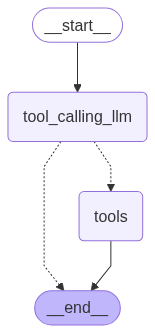

In [ ]:
#StateGraph for Chatbot with tools
from langgraph.graph import StateGraph, START, END
from langgraph.prebuilt import ToolNode
from langgraph.prebuilt import tools_condition

#Node defination
def tool_calling_llm(state:State):
    return { "messages": [llm_with_tools.invoke(state["messages"])]}

#Graph
graph_builder = StateGraph(State)
graph_builder.add_node("tool_calling_llm", tool_calling_llm)
graph_builder.add_node("tools", ToolNode(tools))

#Edges
graph_builder.add_edge(START, "tool_calling_llm")
graph_builder.add_conditional_edges("tool_calling_llm",
                       #If the latest message (result) from assistant is a tool call -> tools_condition routes to tools
                       #If the latest message (result) from assistant is not a tool call -> tools_condition routes to end
                       tools_condition ) #coditional edge
graph_builder.add_edge("tools", END) #after llm execution,

#compile the graph
graph = graph_builder.compile()

from IPython.display import display, Image
display(Image(graph.get_graph().draw_mermaid_png())) #visualize the graph


In [18]:
#Chat bot with tool
graph.invoke({"messages":"What is recent Somalia deals ?"})

{'messages': [HumanMessage(content='What is recent Somalia deals ?', additional_kwargs={}, response_metadata={}, id='cefdab65-755a-435c-9bfe-8aa73d87184b'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'bzxr2v23g', 'function': {'arguments': '{"query":"recent Somalia deals","time_range":"day","topic":"news"}', 'name': 'tavily_search'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 31, 'prompt_tokens': 1855, 'total_tokens': 1886, 'completion_time': 0.049437432, 'prompt_time': 0.12074677, 'queue_time': 0.05326738, 'total_time': 0.170184202}, 'model_name': 'llama-3.1-8b-instant', 'system_fingerprint': 'fp_46fc01befd', 'service_tier': 'on_demand', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--069bf9af-50f3-45b0-a40f-5cbe5c2e8968-0', tool_calls=[{'name': 'tavily_search', 'args': {'query': 'recent Somalia deals', 'time_range': 'day', 'topic': 'news'}, 'id': 'bzxr2v23g', 'type': 'tool_call'}], usage_metadata={'input_tokens': 185

In [19]:
response=graph.invoke({"messages":"What is recent Somalia deals ?"})
response["messages"][-1].content

'{"query": "Somalia deals recent", "follow_up_questions": null, "answer": null, "images": [], "results": [{"url": "https://africa.businessinsider.com/local/lifestyle/ethiopia-alarmed-by-somalia-egypt-arms-shipment-deal/y8k7t1f", "title": "Ethiopia raises alarm over Somalia-Egypt arms shipment deal, says weapons may end up with terrorists - Business Insider Africa", "score": 0.69622743, "published_date": "Tue, 24 Sep 2024 10:48:57 GMT", "content": "Ethiopia Alarmed by Somalia-Egypt Arms Shipment Deal | Business Insider Africa Ethiopia has warned Somalia about the recent arms shipment deal with Egypt, warning that the recent supply of ammunition may complicate efforts to resolve potential conflicts in the region. lifestyle Egyptian warship loaded with military equipment berths in Somalia as tensions soar with Ethiopia In a statement published by Ethiopia\'s state news on Tuesday, Foreign Minister Taye Astke Selassie said that the supply of ammunition by external forces would further dest

In [20]:
for m in response["messages"]:
    m.pretty_print()

================================ Human Message =================================

What is recent Somalia deals ?
================================== Ai Message ==================================
Tool Calls:
  tavily_search (aeyb9ewyx)
 Call ID: aeyb9ewyx
  Args:
    query: Somalia deals recent
    start_date: 2024-02-01
    topic: news
================================= Tool Message =================================
Name: tavily_search

{"query": "Somalia deals recent", "follow_up_questions": null, "answer": null, "images": [], "results": [{"url": "https://africa.businessinsider.com/local/lifestyle/ethiopia-alarmed-by-somalia-egypt-arms-shipment-deal/y8k7t1f", "title": "Ethiopia raises alarm over Somalia-Egypt arms shipment deal, says weapons may end up with terrorists - Business Insider Africa", "score": 0.69622743, "published_date": "Tue, 24 Sep 2024 10:48:57 GMT", "content": "Ethiopia Alarmed by Somalia-Egypt Arms Shipment Deal | Business Insider Africa Ethiopia has warned Somalia abo

In [ ]:
#Testing out custom multiplication tool
response=graph.invoke({"messages":"Multiply 12 and 13"})
for m in response["messages"]:
    m.pretty_print()

================================ Human Message =================================

Multiply 12 and 13
================================== Ai Message ==================================
Tool Calls:
  multiply (036pjjp26)
 Call ID: 036pjjp26
  Args:
    a: 12
    b: 13
================================= Tool Message =================================
Name: multiply

156


In [40]:
#Testing out custom multiplication+Division tool
response=graph.invoke({"messages":"Multiply 12 and 13 and then Divide the answer by 12"})
for m in response["messages"]:
    m.pretty_print()

================================ Human Message =================================

Multiply 12 and 13 and then Divide the answer by 12
================================== Ai Message ==================================
Tool Calls:
  multiply (yd3v54r4f)
 Call ID: yd3v54r4f
  Args:
    a: 12
    b: 13
  divide (gjmctqnzk)
 Call ID: gjmctqnzk
  Args:
    a: 156
    b: 12
================================= Tool Message =================================
Name: multiply

156
================================= Tool Message =================================
Name: divide

13.0


### ReAct Agent Architecture

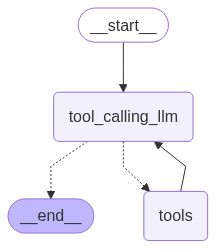

In [41]:
#StateGraph for Chatbot with tools
from langgraph.graph import StateGraph, START, END
from langgraph.prebuilt import ToolNode
from langgraph.prebuilt import tools_condition

#Node defination
def tool_calling_llm(state:State):
    return { "messages": [llm_with_tools.invoke(state["messages"])]}

#Graph
graph_builder = StateGraph(State)
graph_builder.add_node("tool_calling_llm", tool_calling_llm)
graph_builder.add_node("tools", ToolNode(tools))

#Edges
graph_builder.add_edge(START, "tool_calling_llm")
graph_builder.add_conditional_edges("tool_calling_llm",
                       #If the latest message (result) from assistant is a tool call -> tools_condition routes to tools
                       #If the latest message (result) from assistant is not a tool call -> tools_condition routes to end
                       tools_condition ) #coditional edge
graph_builder.add_edge("tools", "tool_calling_llm") #after llm execution, ReAct architecture

#compile the graph
graph = graph_builder.compile()

from IPython.display import display, Image
display(Image(graph.get_graph().draw_mermaid_png())) #visualize the graph


In [44]:
#Testing out custom WebSearch+multiplication+Division tool
response=graph.invoke({"messages":"Whats new in AgenticAi and Multiply 12 and 13 divide the result by 12"})
for m in response["messages"]:
    m.pretty_print()

================================ Human Message =================================

Whats new in AgenticAi and Multiply 12 and 13 divide the result by 12
================================== Ai Message ==================================
Tool Calls:
  tavily_search (8jmtssmf8)
 Call ID: 8jmtssmf8
  Args:
    query: AgenticAi latest news
  divide (n641jbmfg)
 Call ID: n641jbmfg
  Args:
    a: 156
    b: 12
================================= Tool Message =================================
Name: tavily_search

{"query": "AgenticAi latest news", "follow_up_questions": null, "answer": null, "images": [], "results": [{"url": "https://aibusiness.com/generative-ai/agentic-ai", "title": "Agentic AI recent news | AI Business", "content": "Most Read: NiCE Acquires Agentic AI Company in $955M Deal; Department of Energy Unveils First Four AI Data Center Sites · Aug 1, 2025 ; NiCE Acquires Agentic AI", "score": 0.77893573, "raw_content": null}, {"url": "https://www.forbes.com/topics/agentic-ai/", "title": 